In [ ]:
#Mini Project: Ride Price Estimation System
#14 Features, Regression + Classification

# 1.ML MINDSET & PROBLEM FRAMING

# Learning problem:
# Predict the fare_amount of a ride using trip, temporal, spatial,
# demand, and service-related features. Additionally, classify rides
# as High-Cost or Low-Cost.

# Why ML instead of fixed rules?
# Ride pricing is influenced by many interacting variables (distance, time, traffic, demand, weather, location). Fixed rules cannot capture these interactions reliably, while ML can learn patterns from historical data.

# What the model learns:
# ->How each feature contributes to fare_amount
# ->How combinations of features lead to high-cost rides


In [ ]:

# 2.IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report
)



In [ ]:

# 3.LOAD & EXPLORE DATA
df= pd.read_csv(r"C:\Users\betya\OneDrive\Desktop\ride-price-ml\data\rides.csv")
df.head(100)
df.info()

print(df.head())
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                200 non-null    object 
 1   distance_km        200 non-null    float64
 2   trip_duration_min  200 non-null    float64
 3   time_of_day        200 non-null    object 
 4   traffic_level      200 non-null    object 
 5   weather_condition  200 non-null    object 
 6   demand_level       200 non-null    object 
 7   ride_type          200 non-null    object 
 8   passenger_count    200 non-null    int64  
 9   pickup_datetime    200 non-null    object 
 10  pickup_longitude   200 non-null    float64
 11  pickup_latitude    200 non-null    float64
 12  dropoff_longitude  200 non-null    float64
 13  dropoff_latitude   200 non-null    float64
 14  fare_amount        200 non-null    float64
dtypes: float64(7), int64(1), object(7)
memory usage: 23.6+ KB
      key  dista


Missing values per column:
 key                  0
distance_km          0
trip_duration_min    0
time_of_day          0
traffic_level        0
weather_condition    0
demand_level         0
ride_type            0
passenger_count      0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
fare_amount          0
dtype: int64


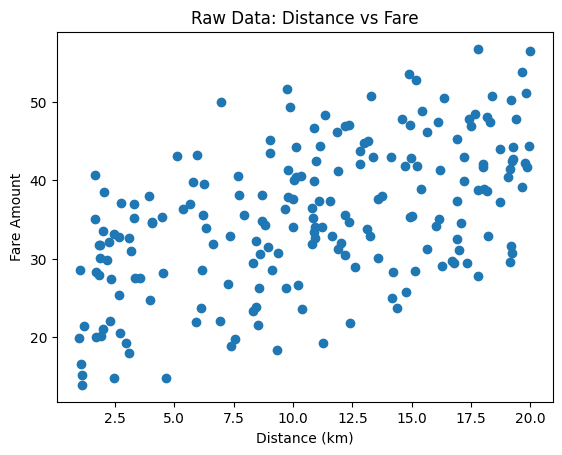

In [ ]:

#4.DATA CLEANING & FEATURE ENGINEERING (GIGO PRINCIPLE)
# ---- Handle missing values ----
df.isnull().sum() #checking missing values
print("\nMissing values per column:\n", df.isnull().sum())

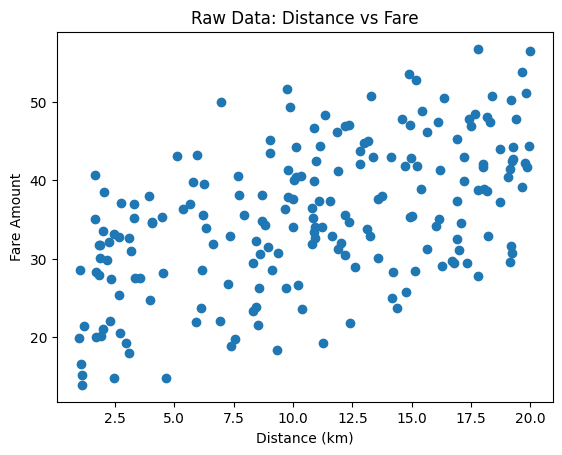

In [ ]:

#Raw visualization
plt.scatter(df['distance_km'], df['fare_amount'])
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount")
plt.title("Raw Data: Distance vs Fare")
plt.show()


In [14]:
#handling duplicates
duplicate_rows= df[df.duplicated(keep=False)]
duplicate_rows

,key,distance_km,trip_duration_min,time_of_day,traffic_level,weather_condition,demand_level,ride_type,passenger_count,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount


In [15]:
#Remove duplicates
df = df.drop_duplicates()



In [16]:
#outline detection 
df.describe()
z = np.abs((df['fare_amount'] - df['fare_amount'].mean()) / df['fare_amount'].std())
df = df[z < 3]

In [17]:
#Datetime feature extraction
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek



In [18]:
# Drop original datetime (not directly usable by models)
df.drop('pickup_datetime', axis=1, inplace=True)



In [19]:
#Drop non-informative feature
# key is an identifier, not a predictive feature
df.drop('key', axis=1, inplace=True)

#Encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)


In [20]:

# 5. DATASET JUSTIFICATION 
# 1. distance_km (Numerical)
# Reason: Distance directly impacts fuel consumption and base fare.
# Influence: Positive correlation – longer distance generally increases fare.

# 2. trip_duration_min (Numerical)
# Reason: Pricing often includes time-based components.
# Influence: Longer duration increases fare, even for short distances
#           when traffic or delays are present.

# 3. pickup_longitude & pickup_latitude (Numerical)
# Reason: Pickup location affects congestion, demand, and route options.
# Influence: Urban or high-demand zones tend to have higher prices.

# 4. dropoff_longitude & dropoff_latitude (Numerical)
# Reason: Destination determines route length and traffic exposure.
# Influence: Trips ending in busy or distant areas often cost more.

# 5. passenger_count (Numerical)
# Reason: Reflects ride usage and potential vehicle size requirements.
# Influence: Higher passenger counts may slightly increase fare.

# 6. pickup_hour (Derived from pickup_datetime)
# Reason: Captures peak vs off-peak travel times.
# Influence: Rush hours and late-night rides often cost more.

# 7. pickup_dayofweek (Derived from pickup_datetime)
# Reason: Demand patterns differ between weekdays and weekends.
# Influence: Weekend rides may have higher or more volatile pricing.

# 8. traffic_level (Categorical)
# Reason: Traffic increases travel time and operational cost.
# Influence: High traffic leads to higher fares.

# 9. weather_condition (Categorical)
# Reason: Adverse weather affects driving difficulty and demand.
# Influence: Rain, fog, or snow can trigger price increases.

# 10. demand_level (Categorical)
# Reason: Ride-hailing platforms adjust prices based on supply-demand balance.
# Influence: High demand leads to surge pricing.

# 11. ride_type (Categorical)
# Reason: Different service tiers have different base fares.
# Influence: Premium rides are consistently more expensive.

# Excluded Feature:
# Driver rating / vehicle ID were considered but excluded.
# Reason: In automated pricing systems, fares are independent of individual
# driver performance. Including them would introduce bias and reduce
# generalization.


In [21]:

# 6. LINEAR REGRESSION MODEL – PRICE PREDICTION

X = df_encoded.drop('fare_amount', axis=1)
y = df_encoded['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Regression Results
R2 Score: 0.9999999027446291
MAE: 0.002386314563232883


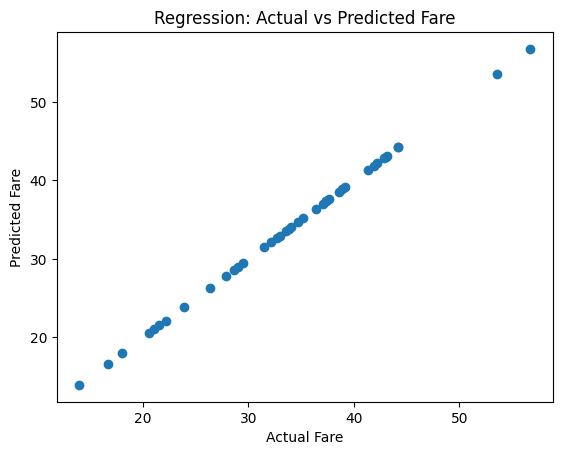

In [ ]:

#Feature scaling (AFTER split, X only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train Linear Regression
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)

#Predict
y_pred = reg_model.predict(X_test_scaled)

#Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Regression Results")
print("R2 Score:", r2)
print("MAE:", mae)

#Plot actual vs predicted
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Regression: Actual vs Predicted Fare")
plt.show()

In [ ]:

# 7. CLASSIFICATION MODEL- LOGISITIC REGRESSION – HIGH COST VS LOW COST

# Binary target creation
threshold = df['fare_amount'].median()
df_encoded['high_cost'] = (df_encoded['fare_amount'] > threshold).astype(int)

X_cls = df_encoded.drop(['fare_amount', 'high_cost'], axis=1)
y_cls = df_encoded['high_cost']




Logistic Regression Results
Accuracy: 0.9500

Confusion Matrix:
[[29  1]
 [ 2 28]] 

Classification Report:
              precision    recall  f1-score   support

    Low Cost       0.94      0.97      0.95        30
   High Cost       0.97      0.93      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [ ]:
#Scale features
scaler = StandardScaler()
X_cls_scaled = scaler.fit_transform(X_cls)

X_train, X_test, y_train, y_test = train_test_split(
    X_cls_scaled,
    y_cls,
    test_size=0.3,
    random_state=42,
    stratify=y_cls
)


log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)



In [ ]:
#Prediction 
y_pred_cls = log_model.predict(X_test)



In [ ]:
#Evaluation
accuracy = accuracy_score(y_test, y_pred_cls)
cm = confusion_matrix(y_test, y_pred_cls)
report = classification_report(
    y_test,
    y_pred_cls,
    target_names=['Low Cost', 'High Cost']
)



In [ ]:
print("\nLogistic Regression Results")
print(f"Accuracy: {accuracy:.4f}\n")
print("Confusion Matrix:")
print(cm, "\n")
print("Classification Report:")
print(report)

# Probabilities explanation:
# Logistic Regression outputs probabilities between 0 and 1.
# A decision threshold (usually 0.5) converts probabilities to classes.


In [ ]:

# 8. MODEL EVALUATION & COMPARISON

# Regression provides exact fare estimates
# Classification provides decision-level insight (expensive or not)
# Data quality issues would distort both predictions and class boundaries
# Most influential features are typically distance, duration, demand, traffic


# 9. ETHICAL & PRACTICAL REFLECTION

# Unfair pricing risk: Surge pricing may disadvantage low-income users
# Deployment risk: Poor generalization to unseen weather or traffic patterns
# Dataset limitation: Synthetic data may not capture real rider behavior
